In [47]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [48]:
#defining the constant to use/refer in the later part

In [49]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [50]:
#loading data into tf.Dataset

In [51]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
    

Found 4500 files belonging to 3 classes.


In [52]:
class_names = dataset.class_names
class_names


['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [53]:
#data visulisation of 16 images from the 1st batch of dataset

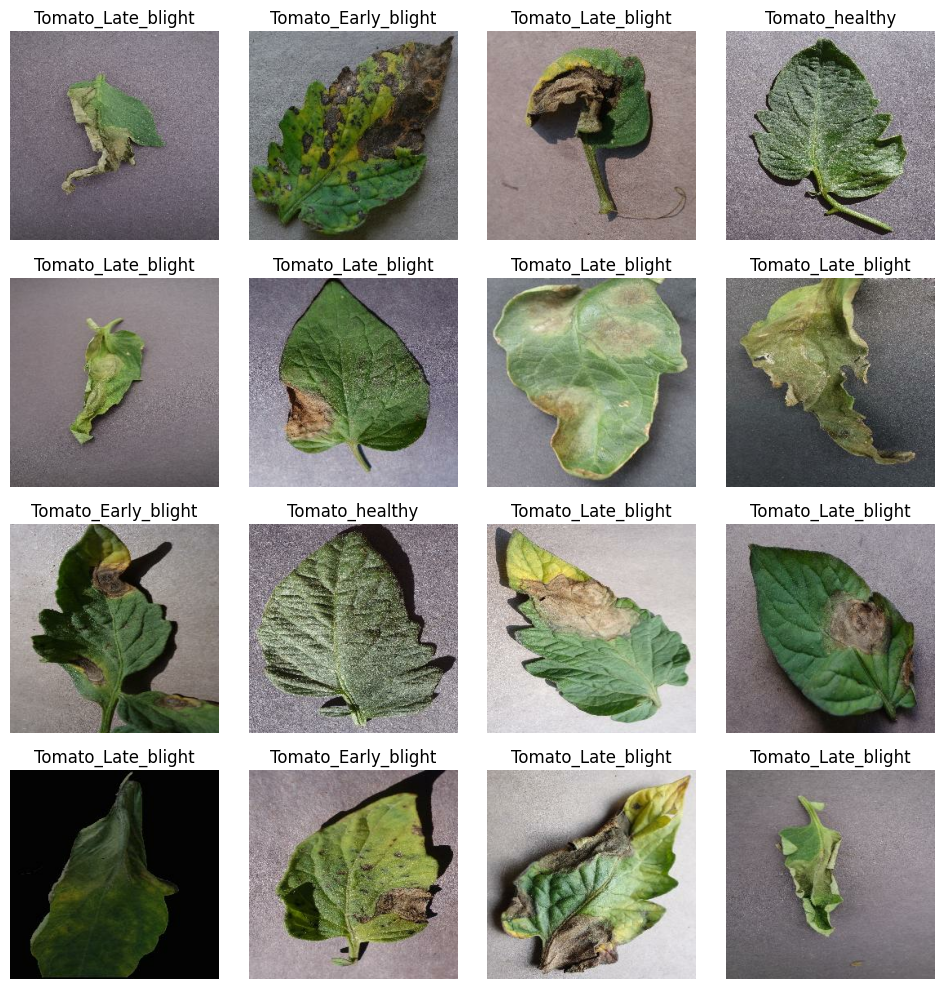

In [54]:
plt.figure(figsize=(10,10)) #changing size of image so they are evenly spaced
for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1) #adjust the num of rows and columns
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        plt.tight_layout() # Adjust subplot parameters to avoid overlap
    

In [55]:
# train, test and split

In [56]:
len(dataset)

141

In [57]:
train_size = 0.8 #80% is the train size
len(dataset)*train_size #get the total batch for the training

112.80000000000001

In [58]:
train_ds = dataset.take(112) #take 112 from the dataset
len(train_ds)

112

In [59]:
rem_ds = dataset.skip(112) #since train is 112, skip that and put in remaining dataset
len(rem_ds)

29

In [60]:
val_size = 0.1 #validation size is 10%
len(dataset)*val_size #get the validation size

14.100000000000001

In [61]:
val_ds = rem_ds.take(14) #take 14 batch from remaining dataset(rem_ds)
len(val_ds)

14

In [62]:
test_ds = rem_ds.skip(14) #for test dataset (test_ds), skip 14 from rem_ds
len(test_ds)

15

In [63]:
#function for spliting dataset

In [64]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [65]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [66]:
len(train_ds)

112

In [67]:
len(val_ds)

14

In [68]:
len(test_ds)

15

In [69]:
#Cache, Shuffle, Prefetch for the optimisation of dataset for doing the training fast

In [70]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [71]:
#Layer needed for normalisation and resizing OR for preprocessing later

In [72]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [73]:
#data augmentation for preprocessing

In [74]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [75]:
#Using data augmentation for dataset (Train-dataset)

In [76]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [77]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [78]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [79]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [80]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
112/112 [==============================] - 105s 799ms/step - loss: 1.0063 - accuracy: 0.4479 - val_loss: 0.8824 - val_accuracy: 0.5246
Epoch 2/50
112/112 [==============================] - 57s 505ms/step - loss: 0.7324 - accuracy: 0.6417 - val_loss: 0.6066 - val_accuracy: 0.7589
Epoch 3/50
112/112 [==============================] - 60s 535ms/step - loss: 0.6001 - accuracy: 0.7550 - val_loss: 0.8502 - val_accuracy: 0.6607
Epoch 4/50
112/112 [==============================] - 61s 548ms/step - loss: 0.4306 - accuracy: 0.8267 - val_loss: 0.3529 - val_accuracy: 0.8504
Epoch 5/50
112/112 [==============================] - 62s 551ms/step - loss: 0.3133 - accuracy: 0.8645 - val_loss: 0.3624 - val_accuracy: 0.8371
Epoch 6/50
112/112 [==============================] - 63s 564ms/step - loss: 0.3041 - accuracy: 0.8729 - val_loss: 0.3806 - val_accuracy: 0.8415
Epoch 7/50
112/112 [==============================] - 64s 567ms/step - loss: 0.2643 - accuracy: 0.8897 - val_loss: 0.4434 - val_a

In [88]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 5s 288ms/step - loss: 0.1573 - accuracy: 0.9479


In [ ]:
#The accuracy is pretty promising with 0.95% for the test dataset